<a href="https://colab.research.google.com/github/sgulyano/aic402/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIC-402 Lab 2: Clustering Applications

CMKL University

By Sarun Gulyanon


### Goal

In this lab, we explore practical applications of clustering as an unsupervised learning technique. Students will learn how clustering can be used to discover structure in data and how it can support downstream tasks such as image understanding and learning with limited labels.

### Outline

In this lab, we will explore the following topics:

1. Using Clustering for Image Segmentation
2. Using Clustering for Semi-Supervised Learning

----

# 1. Using Clustering for Image Segmentation

Apply clustering algorithms to group pixels or patches based on similarity, enabling unsupervised image segmentation and visual abstraction.

In [6]:
# extra code – downloads the ladybug image

from pathlib import Path
import urllib.request

homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
filename = "ladybug.png"
# IMAGES_PATH = Path() / "images" / "unsupervised_learning"
# IMAGES_PATH.mkdir(parents=True, exist_ok=True)
filepath = Path() / filename
if not filepath.is_file():
    print("Downloading", filename)
    url = f"{homl3_root}/images/unsupervised_learning/{filename}"
    urllib.request.urlretrieve(url, filepath)

Download sample image

In [7]:
import numpy as np
import PIL

image = np.asarray(PIL.Image.open(filepath))
image.shape

(533, 800, 3)

array([[[ 25,  29,   2],
        [ 24,  28,   1],
        [ 24,  29,   0],
        ...,
        [ 57, 105,  21],
        [ 56, 103,  22],
        [ 52,  99,  19]],

       [[ 24,  28,   1],
        [ 23,  27,   0],
        [ 23,  27,   0],
        ...,
        [ 60, 108,  22],
        [ 59, 106,  25],
        [ 55, 102,  22]],

       [[ 23,  27,   2],
        [ 22,  26,   1],
        [ 22,  26,   0],
        ...,
        [ 66, 114,  28],
        [ 63, 111,  27],
        [ 58, 105,  24]],

       ...,

       [[ 14,  18,   1],
        [ 14,  18,   1],
        [ 13,  20,   2],
        ...,
        [ 13,  61,   3],
        [  9,  56,   2],
        [  5,  51,   2]],

       [[ 14,  18,   1],
        [ 14,  18,   1],
        [ 12,  19,   1],
        ...,
        [ 11,  59,   1],
        [  7,  54,   0],
        [  3,  49,   0]],

       [[ 13,  17,   0],
        [ 13,  17,   0],
        [ 11,  18,   0],
        ...,
        [ 10,  58,   0],
        [  5,  52,   0],
        [  2,  48,   0]]], dtype=uint8)
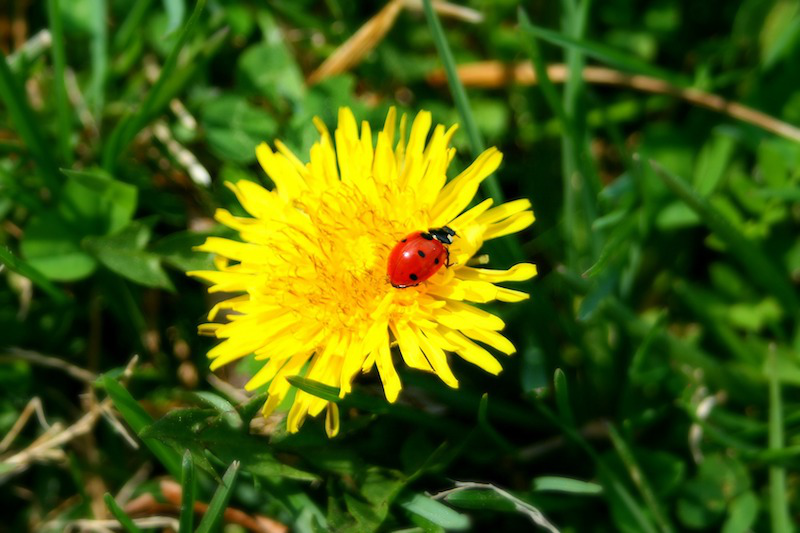

In [9]:
image

Use K-Means clustering to segment an image based on color similarity. The algorithm learns a small set of representative colors and assigns each pixel to one of them. This produces a simplified image that reveals coarse structure without using any labels.

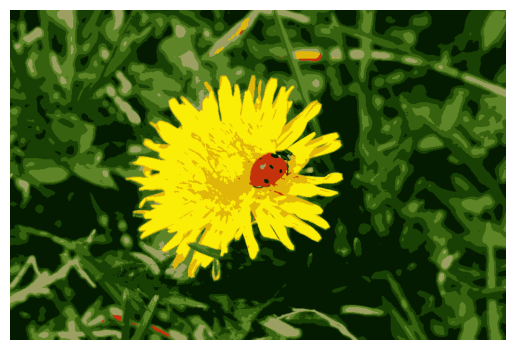

In [11]:
from sklearn.cluster import KMeans

X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

plt.figure()
plt.imshow(segmented_img / 255)
plt.axis('off')
plt.show()

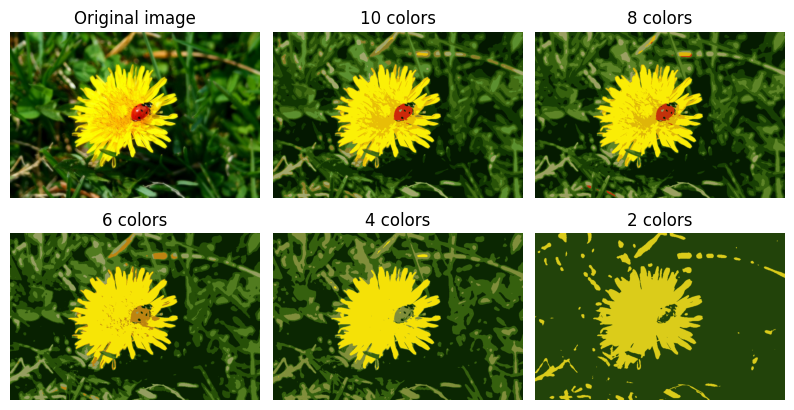

In [12]:
import matplotlib.pyplot as plt

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(2, 3, 2 + idx)
    plt.imshow(segmented_imgs[idx] / 255)
    plt.title(f"{n_clusters} colors")
    plt.axis('off')

plt.show()

# 2. Using Clustering for Semi-Supervised Learning

Another use case for clustering is semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's tackle the _digits dataset_ which is a simple MNIST-like dataset containing 1,797 grayscale 8×8 images representing digits 0 to 9.

In [13]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1400], y_digits[:1400]
X_test, y_test = X_digits[1400:], y_digits[1400:]

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [14]:
from sklearn.linear_model import LogisticRegression

n_labeled = 50
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=10000)

In [15]:
log_reg.score(X_test, y_test)

0.7581863979848866

As a baseline, the accuracy when we use the whole training set is:

In [16]:
log_reg_full = LogisticRegression(max_iter=10_000)
log_reg_full.fit(X_train, y_train)
log_reg_full.score(X_test, y_test)

0.9093198992443325

Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [17]:
k = 50
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = X_digits_dist.argmin(axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

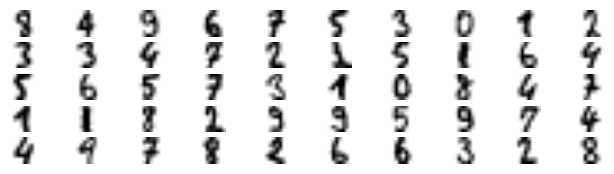

In [18]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')
plt.show()

In [19]:
y_representative_digits = np.array([
     8, 4, 9, 6, 7, 5, 3, 0, 1, 2,
     3, 3, 4, 7, 2, 1, 5, 1, 6, 4,
     5, 6, 5, 7, 3, 1, 0, 8, 4, 7,
     1, 1, 8, 2, 9, 9, 5, 9, 7, 4,
     4, 9, 7, 8, 2, 6, 6, 3, 2, 8
])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [20]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8387909319899244

We jumped from 74.8% accuracy to 84.9%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But we can go one step further: after clustering the data, we can propagate the label of a labeled example to all other samples within the same cluster. This assumes that points grouped together by the clustering algorithm are likely to share the same class. In this way, clustering becomes a tool for semi-supervised learning, allowing a small number of labels to influence many unlabeled instances.

In [22]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [23]:
log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=10000)

In [24]:
log_reg.score(X_test, y_test)

0.8589420654911839

----